In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import time

# Simple function to Maximimze

1.988950304427771


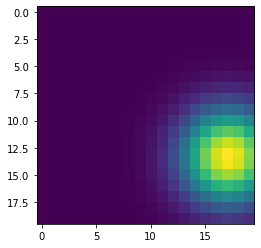

1.9889503044278196


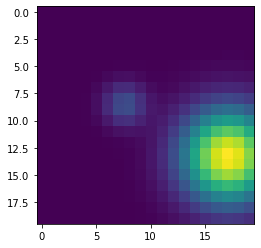

In [2]:
def hard(x,y):
    """Local maximum near (0,0) but a global maximum if you travel further out"""
    return 2*np.exp(-((x-4)**2+(y-2)**2)/5)+0.5*np.exp(-(x+1)**2-(y+0.5)**2)

def easy(x,y):
    """Only has a global maximum if you travel further out"""
    return 2*np.exp(-((x-4)**2+(y-2)**2)/5)

X,Y=np.meshgrid(*[np.linspace(-5,5,20)]*2)
plt.imshow(easy(X,Y))

print(np.max(easy(X,Y)))
plt.show()

plt.imshow(hard(X,Y))

print(np.max(hard(X,Y)))

# Discrete gym for maximizing the function

In [3]:
class MaxGym(gym.Env):
    def __init__(self,function=easy,length=100):
        """
        Define the action and observation space here
        """
        
        self.length=length
        
        #action space setup
        self.xadd= [0,     -0.1,-0.02,0.02,0.1,0,   0,    0,   0  ]
        self.yadd= [0,     0,   0,    0,   0,  -0.1,-0.02,0.02,0.1]
        
        #Set the action and observation space
        self.observation_space = spaces.Box(low=0,high=255,shape=[2],dtype='uint8')
        self.action_space= spaces.Discrete(9)
        #distance is used in reward calculation
        self.height=0
        self.f=function
        self.reset()
        
    def step(self,action):
        """
        Update the environment by performing an action.

        Inputs:
            action (int) - index of the action to perform.
                Action:         [0,     1,      2,      3,      4,      5,      6,      7,      8]
                Add to X:       [0,     -0.1,   -0.02,  0.02,   0.1,    0,      0,      0,      0]
                Add to Y:       [0,     0,      0,      0,      0,      -0.1,   -0.02,  0.02, 0.1]
        
        Outputs:
            state - shape [2] numpy array
                A numpy array containing state variables.
            reward (float) - reward given during this timestep
                The amount of reward generated in perfoming the action.
            done (bool) - Whether or not the final state has been reached and the episode is completed
            params (dict) - unused
        """
        self.idx+=1
        #action gives change to inverse temp and mew
        self.x+=self.xadd[action]
        self.y+=self.yadd[action]
        #keep temperature and field strength within reasonable limits
        self.x=max(min(self.x,5.0),-5.0)
        self.y=max(min(self.y,5.0),-5.0)
        
        outstate = np.array([self.x,self.y])
        #get new evaluation
        oldheight=self.height
        self.height=self.f(self.x,self.y)
            
        return outstate, self.height-oldheight, self.idx>=self.length, {}
          
    def reset(self):
        '''
        Initialize the environment. This sets the x and y position back to 0
        Outputs:
            state - shape [2] numpy array
        '''
        #reset the position
        self.x=self.y=self.idx=0
        #self.rew actually just tells you the return of the last episode and is used for debugging
        self.rew=self.height
        #reset the distance from the target point
        self.height=0
        #generate a random accessable point in phase space
        outstate = np.array([self.x,self.y])
        
        return outstate
    def render(self):
        """Render the Environment"""
        X,Y=np.meshgrid(*[np.linspace(-5,5,20)]*2)
        plt.imshow(self.f(X,Y))
        plt.plot(self.x*2+10,self.y*2+10,"r.")
        plt.axis("off")
        plt.show()
        
#register this as an environment (note the entry point will be different if made in a package)        
gym.envs.register(
     id="MaxGym-v0",
     entry_point='__main__:MaxGym',
     kwargs={'function':easy},
)
gym.envs.register(
     id="MaxGym-v1",
     entry_point='__main__:MaxGym',
     kwargs={'function':hard},
)

# Reinforce Algorithm
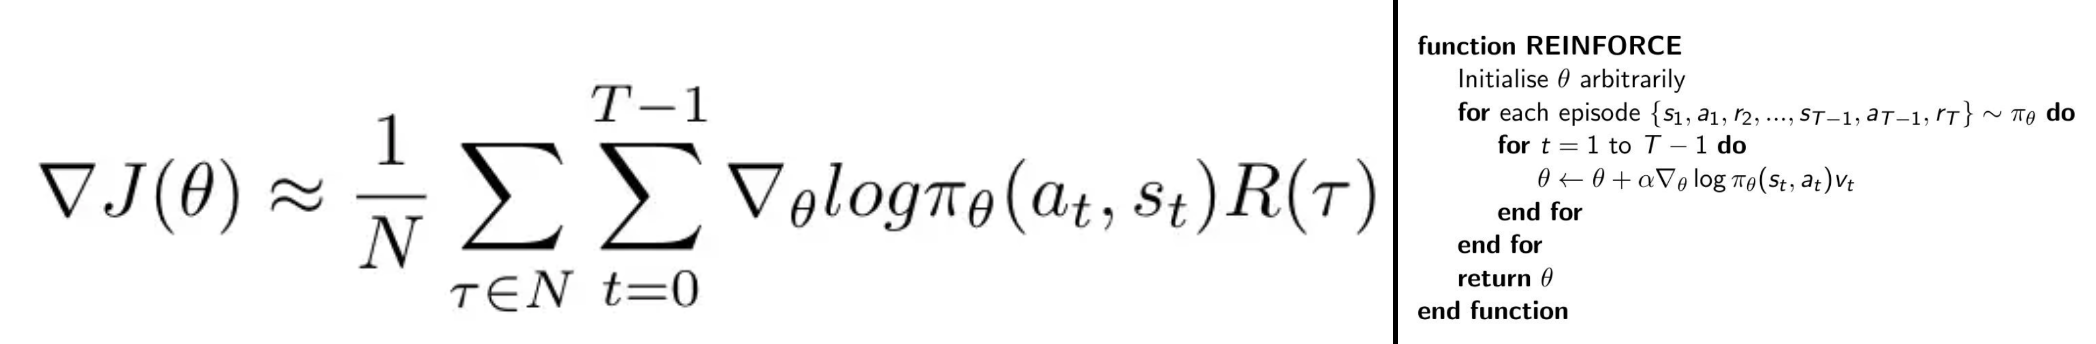

In [4]:
import torch
from torch import nn

In [5]:
class MLPolicy(nn.Module):
    def __init__(self):
        super(MLPolicy, self).__init__()
        self.lin = nn.Sequential(
                nn.Linear(2,32),
                nn.ReLU(),
                nn.Linear(32,32),
                nn.ReLU(),
                nn.Linear(32,9),
                nn.Softmax(dim=-1)
            )
    def forward(self,obs):
        """Takes in an observation and returns an action along with it's probability"""
        probs=self.lin(torch.Tensor(obs))
        act = torch.multinomial(probs,1,False)
        return act.item(),probs[act]

In [6]:
def ascent(theta,alpha):
    for param in theta():
        #add gradients multiplied by the learning rate alpha
        param.data.copy_(param.data+alpha*param.grad.data)
        #zero your gradients
        param.grad.data.zero_()

In [7]:
def REINFORCE(env,policy,B=100,episodes=100,alpha=0.1):
    """Simple implementation of the REINFORCE algorithm"""
    Returns=[]
    for step in range(episodes):
        logp=torch.zeros(B)
        R=torch.zeros(B)
        #collect your trajectories
        for b in range(B):
            obs,done=env.reset(),False
            while not done:
                act,p = policy(obs)
                obs,r,done,_=env.step(act)
                logp[b:b+1]+=torch.log(p)
                R[b]+=r
                
        #Used to get gradients on the objective function
        Jhelper= (R*logp).mean()
        #Compute objective function gradients
        Jhelper.backward()
        #Perform gradient ascent
        ascent(policy.parameters,alpha)
        Returns+=[R.mean().item()]
    return Returns

363.6525037288666


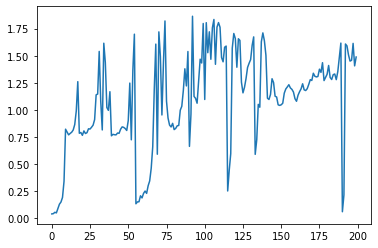

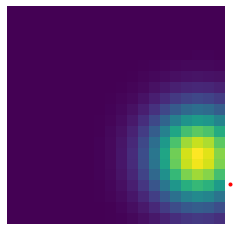

In [8]:
policy = MLPolicy()
env=gym.make("MaxGym-v0")
t=time.time()
ret = REINFORCE(env,policy,B=50,episodes=200)
print(time.time()-t)

plt.plot(ret)
plt.title("Agent Performance")
plt.ylabel("Return (avg)")
plt.xlabel("Episode (sequential)")
plt.show()

env.render()

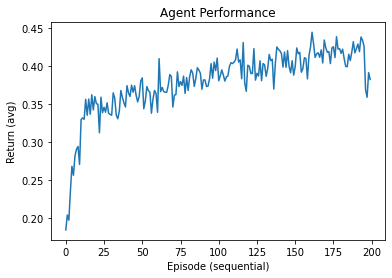

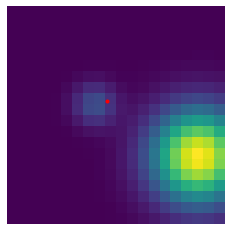

In [11]:
policy2 = MLPolicy()
env=gym.make("MaxGym-v1")
t=time.time()
ret = REINFORCE(env,policy2,B=50,episodes=200)
print(time.time()-t)

plt.plot(ret)
plt.title("Agent Performance")
plt.ylabel("Return (avg)")
plt.xlabel("Episode (sequential)")
plt.show()

env.render()